You can find all the data in `../readonly/final_project_data` folder or download it from [Kaggle](https://inclass.kaggle.com/c/competitive-data-science-final-project) if you are solving locally. 

**Good luck!**

In [ ]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import xgboost as xgb
import matplotlib
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.decomposition import NMF
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

**IMPORT DATA FROM KAGGLE TO GOOGLE COLAB**

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle


In [ ]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tungbinhthuong","key":"5eae00b9438ccb02e61a41defa482fb1"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c competitive-data-science-predict-future-sales
!ls

  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.55MB/s]
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 51.7MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.62MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 65.3MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 69.1MB/s]
 53% 7.00M/13.3M [00:00<00:00, 70.4MB/s]
100% 13.3M/13.3M [00:00<00:00, 84.9MB/s]
item_categories.csv  sales_train.csv.zip	shops.csv
items.csv.zip	     sample_data		test.csv.zip
kaggle.json	     sample_submission.csv.zip


In [ ]:
!unzip sales_train.csv.zip
!unzip shops.csv.zip
!unzip items.csv.zip
!unzip test.csv.zip

Archive:  sales_train.csv.zip
  inflating: sales_train.csv         
unzip:  cannot find or open shops.csv.zip, shops.csv.zip.zip or shops.csv.zip.ZIP.
Archive:  items.csv.zip
  inflating: items.csv               
Archive:  test.csv.zip
  inflating: test.csv                


**LOAD DATA**

In [ ]:
sales = pd.read_csv('/content/sales_train.csv')
shops = pd.read_csv('/content/shops.csv')
items = pd.read_csv('/content/items.csv')
item_cats = pd.read_csv('/content/item_categories.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
test['date_block_num']=34
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [ ]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


**FEATURE EXTRACTION**

In [ ]:
#tf_idf
vectorizer = TfidfVectorizer(max_features = 20)
X = pd.DataFrame(vectorizer.fit_transform(item_cats['item_category_name']).toarray())

In [ ]:
tf_idf = []
for cols in X.columns:
    item_cats['category_tf_idf_'+str(cols+1)] = X[cols]
    tf_idf.append('category_tf_idf_'+str(cols+1))
del X

In [ ]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
#tf_idf
vectorizer = TfidfVectorizer(max_features = 20)
X = pd.DataFrame(vectorizer.fit_transform(shops['shop_name']).toarray())

In [ ]:
for cols in X.columns:
    shops['shop_tf_idf_'+str(cols+1)] = X[cols]
    tf_idf.append('shop_tf_idf_'+str(cols+1))
del X

In [ ]:
items['item_name'].astype(str)
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
#tf_idf
vectorizer = TfidfVectorizer(max_features = 20)
X = pd.DataFrame(vectorizer.fit_transform(items['item_name']).toarray())

In [ ]:
for cols in X.columns:
    items['item_tf_idf_'+str(cols+1)]=X[cols]
    tf_idf.append('item_tf_idf_'+str(cols+1))
del X

**FEATURE MATRIX**

In [ ]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols, as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'], as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'], as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Same as above but with shop-month-mean aggregates (mean-encoding)
gb = sales.groupby(['shop_id', 'date_block_num'], as_index=False).agg({'item_cnt_day':{'target_shop_mean':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month-mean aggregates (mean-encoding)
gb = sales.groupby(['item_id', 'date_block_num'], as_index=False).agg({'item_cnt_day':{'target_item_mean':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)



# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)


In [ ]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_shop_mean,target_item_mean
0,59,22154,0,1.0,2017.0,18.0,1.092041,1.0
1,59,2552,0,0.0,2017.0,0.0,1.092041,0.0
2,59,2554,0,0.0,2017.0,1.0,1.092041,1.0
3,59,2555,0,0.0,2017.0,2.0,1.092041,1.0
4,59,2564,0,0.0,2017.0,5.0,1.092041,1.0


In [ ]:
all_data=pd.concat([all_data, test], ignore_index=True,  keys=['shop_id','item_id','date_block_num']).fillna(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [ ]:
all_data.head()

,ID,date_block_num,item_id,shop_id,target,target_item,target_item_mean,target_shop,target_shop_mean
0,0.0,0,22154,59,1.0,18.0,1.0,2017.0,1.092041
1,0.0,0,2552,59,0.0,0.0,0.0,2017.0,1.092041
2,0.0,0,2554,59,0.0,1.0,1.0,2017.0,1.092041
3,0.0,0,2555,59,0.0,2.0,1.0,2017.0,1.092041
4,0.0,0,2564,59,0.0,5.0,1.0,2017.0,1.092041


**CREATE LAG FEATURES**

In [ ]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols+['item_category_id']+['ID'])) 
# Remember to try from 1->12
shift_range = [1,2,3,4,5,6]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]  

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

In [ ]:
all_data=pd.merge(all_data, items, sort=False, on = ['item_id','item_category_id'], how = 'left')

In [ ]:
all_data=pd.merge(all_data, item_cats, sort=False, on = ['item_category_id'], how = 'left')

In [ ]:
all_data=pd.merge(all_data, shops, sort=False, on = ['shop_id'], how = 'left')
all_data.head()

,ID,date_block_num,item_id,shop_id,target,target_item,target_item_mean,target_shop,target_shop_mean,target_lag_1,target_item_lag_1,target_item_mean_lag_1,target_shop_lag_1,target_shop_mean_lag_1,target_lag_2,target_item_lag_2,target_item_mean_lag_2,target_shop_lag_2,target_shop_mean_lag_2,target_lag_3,target_item_lag_3,target_item_mean_lag_3,target_shop_lag_3,target_shop_mean_lag_3,target_lag_4,...,category_tf_idf_17,category_tf_idf_18,category_tf_idf_19,category_tf_idf_20,shop_name,shop_tf_idf_1,shop_tf_idf_2,shop_tf_idf_3,shop_tf_idf_4,shop_tf_idf_5,shop_tf_idf_6,shop_tf_idf_7,shop_tf_idf_8,shop_tf_idf_9,shop_tf_idf_10,shop_tf_idf_11,shop_tf_idf_12,shop_tf_idf_13,shop_tf_idf_14,shop_tf_idf_15,shop_tf_idf_16,shop_tf_idf_17,shop_tf_idf_18,shop_tf_idf_19,shop_tf_idf_20
0,0.0,12,10297,54,4.0,23.0,1.000000,8198.0,1.295717,3.0,42.0,1.000000,10055.0,1.363205,0.0,2.0,1.000000,7978.0,1.413036,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,"Химки ТЦ ""Мега""",0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
1,0.0,12,10296,54,3.0,17.0,1.000000,8198.0,1.295717,0.0,24.0,1.000000,10055.0,1.363205,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,"Химки ТЦ ""Мега""",0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
2,0.0,12,10298,54,14.0,182.0,1.181818,8198.0,1.295717,21.0,369.0,1.308511,10055.0,1.363205,119.0,1309.0,2.226191,7978.0,1.413036,7.0,144.0,2.526316,6676.0,1.337876,0.0,...,0.0,0.0,0.0,0.0,"Химки ТЦ ""Мега""",0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
3,0.0,12,10300,54,3.0,26.0,0.962963,8198.0,1.295717,1.0,54.0,1.058824,10055.0,1.363205,31.0,361.0,1.367424,7978.0,1.413036,0.0,53.0,1.606061,6676.0,1.337876,0.0,...,0.0,0.0,0.0,0.0,"Химки ТЦ ""Мега""",0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0
4,0.0,12,10284,54,1.0,3.0,1.000000,8198.0,1.295717,0.0,4.0,1.000000,10055.0,1.363205,0.0,3.0,1.000000,7978.0,1.413036,0.0,5.0,1.000000,6676.0,1.337876,0.0,...,0.0,0.0,0.0,0.0,"Химки ТЦ ""Мега""",0.0,0.0,0.0,0.0,0.0,0.866844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49858,0.0,0.0,0.0


**COMPUTE NON-NEGATIVE MATRIX FEATURES FROM TF-IDF**

In [ ]:
nmf = NMF(n_components = 20)
W = nmf.fit_transform(all_data[tf_idf])

In [ ]:
W = pd.DataFrame(W)
W.columns = ['tf_idf_' + str(x) for x in range(0,20)]

#drop previous tf_idf features
all_data.drop(tf_idf, axis = 1, inplace = True)
all_data = pd.concat([all_data,W], axis = 1)

In [ ]:
all_data.drop(['shop_name','item_name','item_category_name'], axis=1, inplace = True)

#
all_data = downcast_dtypes(all_data)

In [ ]:
print(all_data.columns)

Index([                    'ID',         'date_block_num',
                      'item_id',                'shop_id',
                       'target',            'target_item',
             'target_item_mean',            'target_shop',
             'target_shop_mean',           'target_lag_1',
            'target_item_lag_1', 'target_item_mean_lag_1',
            'target_shop_lag_1', 'target_shop_mean_lag_1',
                 'target_lag_2',      'target_item_lag_2',
       'target_item_mean_lag_2',      'target_shop_lag_2',
       'target_shop_mean_lag_2',           'target_lag_3',
            'target_item_lag_3', 'target_item_mean_lag_3',
            'target_shop_lag_3', 'target_shop_mean_lag_3',
                 'target_lag_4',      'target_item_lag_4',
       'target_item_mean_lag_4',      'target_shop_lag_4',
       'target_shop_mean_lag_4',           'target_lag_5',
            'target_item_lag_5', 'target_item_mean_lag_5',
            'target_shop_lag_5', 'target_shop_mean_lag_5

In [ ]:
to_drop_cols=['target_shop', 
              'target', 
              'target_item', 
              'date_block_num',
              'ID',
              #'date_target_mean',
              'target_item_mean',
              'target_shop_mean']

**VALIDATION SCHEME**

In [ ]:
X_test = all_data.loc[all_data['date_block_num']==34].drop(to_drop_cols, axis=1)
y_test = all_data.loc[all_data['date_block_num']==34, 'target'].values


In [ ]:
y_test.shape

(214200,)

In [ ]:
X_train =  all_data[all_data['date_block_num']!=34].drop(to_drop_cols,axis=1)
y_train = all_data.loc[all_data['date_block_num']!=34, 'target'].values

In [ ]:
X_train.head()

,item_id,shop_id,target_lag_1,target_item_lag_1,target_item_mean_lag_1,target_shop_lag_1,target_shop_mean_lag_1,target_lag_2,target_item_lag_2,target_item_mean_lag_2,target_shop_lag_2,target_shop_mean_lag_2,target_lag_3,target_item_lag_3,target_item_mean_lag_3,target_shop_lag_3,target_shop_mean_lag_3,target_lag_4,target_item_lag_4,target_item_mean_lag_4,target_shop_lag_4,target_shop_mean_lag_4,target_lag_5,target_item_lag_5,target_item_mean_lag_5,...,target_item_lag_6,target_item_mean_lag_6,target_shop_lag_6,target_shop_mean_lag_6,item_category_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,10297,54,3.0,42.0,1.000000,10055.0,1.363205,0.0,2.0,1.000000,7978.0,1.413036,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,37,0.010209,0.000000,0.0,0.032501,0.0,0.0,0.0,0.000000,0.003115,0.029606,0.0,0.0,0.000000,0.0,0.0,0.000039,0.0,0.0,0.0,0.0
1,10296,54,0.0,24.0,1.000000,10055.0,1.363205,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,38,0.010209,0.000000,0.0,0.032501,0.0,0.0,0.0,0.000000,0.003115,0.029606,0.0,0.0,0.000000,0.0,0.0,0.000039,0.0,0.0,0.0,0.0
2,10298,54,21.0,369.0,1.308511,10055.0,1.363205,119.0,1309.0,2.226191,7978.0,1.413036,7.0,144.0,2.526316,6676.0,1.337876,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,40,0.019295,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.003108,0.029608,0.0,0.0,0.000000,0.0,0.0,0.000064,0.0,0.0,0.0,0.0
3,10300,54,1.0,54.0,1.058824,10055.0,1.363205,31.0,361.0,1.367424,7978.0,1.413036,0.0,53.0,1.606061,6676.0,1.337876,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,37,0.010209,0.000000,0.0,0.032501,0.0,0.0,0.0,0.000000,0.003115,0.029606,0.0,0.0,0.000000,0.0,0.0,0.000039,0.0,0.0,0.0,0.0
4,10284,54,0.0,4.0,1.000000,10055.0,1.363205,0.0,3.0,1.000000,7978.0,1.413036,0.0,5.0,1.000000,6676.0,1.337876,0.0,3.0,1.0,7827.0,1.428285,0.0,10.0,1.0,...,9.0,1.0,7225.0,1.25543,57,0.000000,0.022484,0.0,0.000000,0.0,0.0,0.0,0.000272,0.003082,0.029571,0.0,0.0,0.020269,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


**TRAINING**

In [ ]:
#train lgb
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test).clip(*[0,20])

#print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)
pred_lr = lr.predict(X_test).clip(*[0,20])

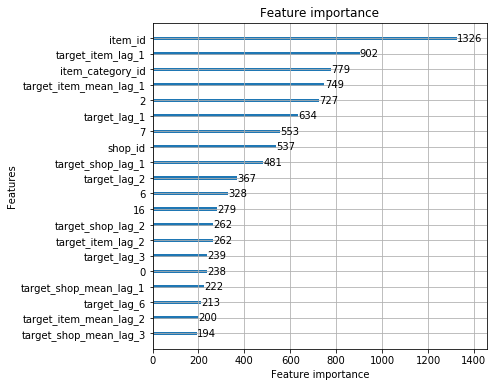

In [ ]:
#importance feature
fig, ax = plt.subplots(figsize = (6,6))
lgb.plot_importance(model, max_num_features = 20, title = 'Feature importance', ax = ax)
plt.show()


In [ ]:
#validation dates
dates = [27, 28, 29, 30, 31, 32, 33]
val_dates = all_data.loc[all_data['date_block_num'] < 34,'date_block_num']

0          12
1          12
2          12
3          12
4          12
           ..
6425089    33
6425090    33
6425091    33
6425092    33
6425093    33
Name: date_block_num, Length: 6425094, dtype: int32

In [ ]:

y_train_level2 = y_train[val_dates.isin([27, 28, 29, 30, 31, 32, 33])]
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

**KFold scheme in time series**

In time-series task we usually have a fixed period of time we are asked to predict. Like day, week, month or arbitrary period with duration of T.

Split the train data into chunks of duration T. Select first M chunks.
Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until you hit the end. After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test.
Now we can use meta-features from first K chunks [M+1,M+2,..,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.

In [ ]:

for cur in dates:
    print('date_block_num: ' +str(cur))
    
    X_train_2 = all_data[all_data['date_block_num'] < cur].drop(to_drop_cols,axis=1)
    y_train_2 = all_data[all_data['date_block_num'] < cur].target.values
    #create meta features    
    lr = LinearRegression()
    lr.fit(X_train_2,y_train_2)
    
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_train_2, label=y_train_2), 100)
    
    X_val_2 = all_data[all_data['date_block_num'] == cur].drop(to_drop_cols,axis=1)
    y_val_2 = all_data[all_data['date_block_num'] == cur].target.values
    
    #meta features
    y_hat_lr_2 = lr.predict(X_val_2).clip(*[0,20])
    X_train_level2[cur == val_dates[val_dates >= 27],0] = y_hat_lr_2
    y_hat_lgb_2 = model_lgb.predict(X_val_2).clip(*[0,20])
    X_train_level2[cur == val_dates[val_dates >= 27],1] = y_hat_lgb_2

date_block_num: 27
date_block_num: 28
date_block_num: 29
date_block_num: 30
date_block_num: 31
date_block_num: 32
date_block_num: 33


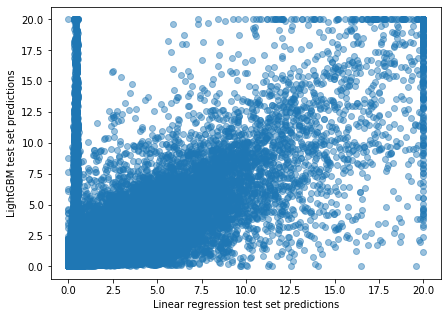

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(X_train_level2[:,0], X_train_level2[:,1], alpha=0.45)
plt.xlabel('Linear regression test set predictions')
plt.ylabel('LightGBM test set predictions')
plt.show()

In [ ]:
X_test_level2 = np.c_[pred_lr,pred_lgb]

**STACKING**

In [ ]:
lr = LinearRegression()
lr.fit(X_train_level2,y_train_level2)
y_hat_level2 = lr.predict(X_train_level2).clip(*[0,20])

In [ ]:
r2_score(y_train_level2, y_hat_level2)

0.07897083984674247

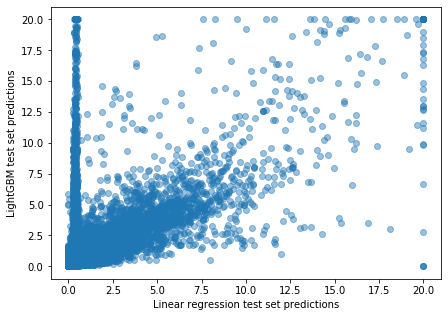

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(X_test_level2[:,0], X_test_level2[:,1], alpha = 0.45)
plt.xlabel('Linear regression test set predictions')
plt.ylabel('LightGBM test set predictions')
plt.show()

**SIMPLE CONVEX MIX**

In [ ]:
alphas_to_try = np.linspace(0, 1, 1001)
score=[]
alpha_max=0

for a in alphas_to_try:
    _X = np.matmul(X_train_level2,[a,1-a])
    score.append(r2_score(y_train_level2 , _X))

best_alpha = alphas_to_try[np.argmax(score)]
r2_train_simple_mix = r2_score(y_train_level2 , np.matmul(X_train_level2,[best_alpha , 1-best_alpha]))

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha , r2_train_simple_mix))

Best alpha: 0.000000; Corresponding r2 score on train: 0.086214


In [ ]:
best_alpha

0.0

From different tries, I found that simple convex mix yield better score on the public score than stacking.

In [ ]:
test_preds = np.matmul(X_test_level2,[best_alpha, 1-best_alpha])
submit = pd.DataFrame(test_preds)

In [ ]:
submission = pd.concat([test,submit],axis=1)
submission.drop(['shop_id','item_id','date_block_num'], axis = 1, inplace = True)

In [ ]:
submission.columns=['ID','item_cnt_month']

In [ ]:
submission.head()

,ID,item_cnt_month
0,0,0.462138
1,1,0.122792
2,2,1.006770
3,3,0.326454
4,4,2.287561


In [ ]:
submission.to_csv('b.csv',index=False)